In [1188]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey, normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, ks_2samp, chi2, f
import pickle
from datetime import datetime
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from backwards_regression import fit_linear_regression


In [1189]:
####################### Importing data and Stationarity test ##############################################
data = pd.read_pickle("data_v1.pickle")
data_shifted = pd.read_pickle("data_v1_offset.pickle")

def test_stationarity(series, name, alpha=0.01):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"{name}: p-value = {p_value:.4f} -> ", end='')
    if p_value < alpha:
        print("Stationary ✅")
    else:
        print("Not stationary ❌")

# Example: apply to all columns in your dataset
for col in data.columns:
    test_stationarity(data[col], col)

data_shifted


Equity Factor: p-value = 0.0000 -> Stationary ✅
network_active_stake: p-value = 0.0001 -> Stationary ✅
SOL_mc: p-value = 0.0000 -> Stationary ✅
SOL_volume: p-value = 0.0000 -> Stationary ✅
SOL_fr: p-value = 0.0000 -> Stationary ✅
TVL_USD: p-value = 0.0000 -> Stationary ✅
apy block: p-value = 0.0000 -> Stationary ✅
apy jito: p-value = 0.0000 -> Stationary ✅
Mkt Vol Factor: p-value = 0.0000 -> Stationary ✅
ECSURPUS Index: p-value = 0.0000 -> Stationary ✅
Econ Surprise Factor: p-value = 0.0000 -> Stationary ✅
US 10Y Rate Level Factor: p-value = 0.0000 -> Stationary ✅
US 2Y Rate Level Factor: p-value = 0.0000 -> Stationary ✅
US 3M Rate Level Factor: p-value = 0.0025 -> Stationary ✅
Tsy Bond Factor: p-value = 0.0000 -> Stationary ✅
DXY Factor: p-value = 0.0000 -> Stationary ✅
FEDL01 Index: p-value = 0.0000 -> Stationary ✅
Commodity Factor: p-value = 0.0000 -> Stationary ✅
CPI YOY Index: p-value = 0.0000 -> Stationary ✅
Inflation Factor: p-value = 0.0000 -> Stationary ✅
Risk-on/Risk-off Fact

,Equity Factor,network_active_stake,SOL_mc,SOL_volume,SOL_fr,TVL_USD,apy block,apy jito,Mkt Vol Factor,ECSURPUS Index,...,Nominal Rates Factor,FEDL01 Change Factor,Curve Shape,Equity Weight,Tsy Bond Weight,Risk Parity Factor,rSOL,rETH,rBTC,rnetwork_active_stake
2023-01-14,0.000000,384323054.0,0.957322,0.819833,0.883365,-0.108512,-0.561054,3.678768,0.683808,-1.368939,...,-0.334658,5.294651,-1.637280,2.337316,-2.337316,1.978037,0.284801,0.063792,0.052620,0.000000
2023-01-15,0.000000,384605714.0,0.746700,-0.282060,0.800185,-0.029683,0.009898,2.782767,0.602020,-1.273049,...,0.717212,-0.182574,3.020347,1.790003,-1.790003,1.396458,-0.062189,0.001428,-0.007928,0.000735
2023-01-16,-0.002033,384605714.0,-1.888572,0.321945,0.252141,-3.232688,0.038411,2.394137,0.651976,-1.187855,...,0.163950,-0.182574,0.010366,1.359884,-1.359884,1.053000,0.032246,0.016875,0.015328,0.000000
2023-01-17,-0.015685,384605714.0,-1.365256,-0.489778,0.093588,-3.005429,1.139328,0.630920,0.670035,-1.117382,...,0.206241,-0.182574,-0.008663,1.003488,-1.003488,0.753701,-0.030319,-0.005208,-0.000877,0.000000
2023-01-18,-0.007668,378324461.0,-1.338724,-1.373072,0.112007,-2.727105,1.091946,0.594033,0.554810,-0.919313,...,1.850013,-0.182574,0.762071,0.496074,-0.496074,0.105998,-0.092613,-0.034335,-0.020531,-0.016467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-14,0.004124,388734676.0,0.380548,0.110866,0.178177,0.558068,0.966718,1.184378,0.243385,0.217017,...,-1.861711,0.182574,-0.160554,-0.202831,0.202831,-0.572991,-0.042162,-0.027622,-0.005680,0.000000
2025-05-15,0.006981,390142087.0,0.537064,0.483777,-0.382410,0.573292,0.908799,1.108122,0.148393,0.526922,...,-0.653209,0.182574,-0.883395,-0.127370,0.127370,-0.441917,-0.044632,-0.023873,0.001104,0.003614
2025-05-16,0.000000,390142087.0,0.188808,-0.264354,-0.271554,0.481587,2.138766,2.225174,0.345609,1.494576,...,-0.860642,0.182574,0.203254,-0.150126,0.150126,-0.462145,-0.005852,0.000822,-0.001475,0.000000
2025-05-17,0.000000,389388940.0,0.728672,0.444103,1.307276,0.958675,1.923639,1.992163,0.044284,-1.377426,...,0.718305,0.182574,0.189319,-0.188089,0.188089,-0.615984,-0.010960,-0.027627,-0.003324,-0.001932


In [1190]:
####################### Data Split ###############################################################################################################################

data_train = data[data.index < datetime(2025,1,1)]
data_test = data[data.index >= datetime(2025,1,1)]

data_shifted_train = data_shifted[data_shifted.index < datetime(2025,1,1)]
data_shifted_test = data_shifted[data_shifted.index >= datetime(2025,1,1)]


In [1191]:
####################### Variables Selection ######################################################################################################################

exo_variables = ["SOL_mc","SOL_volume","SOL_fr","Equity Factor","Mkt Vol Factor",
                      "Econ Surprise Factor","Tsy Bond Factor","DXY Factor","Commodity Factor", 
                      "Inflation Factor","Risk-on/Risk-off Factor",
                      "Nominal Rates Factor","FEDL01 Change Factor","Curve Shape",
                      "Risk Parity Factor","rETH","rBTC","apy block", "apy jito","rnetwork_active_stake","TVL_USD"]


kept_exo_variables = ['Commodity Factor', 'rETH', 'rBTC', 'apy block',"rnetwork_active_stake","TVL_USD"]



y_train = data_train["rSOL"]
y_test = data_test["rSOL"]
y_train.index = pd.DatetimeIndex(y_train.index, freq='D')
y_test.index = pd.DatetimeIndex(y_test.index, freq='D')

y_shifted_train = data_shifted_train["rSOL"]
y_shifted_test = data_shifted_test["rSOL"]
y_shifted_train.index = pd.DatetimeIndex(y_shifted_train.index, freq='D')
y_shifted_test.index = pd.DatetimeIndex(y_shifted_test.index, freq='D')

X_train = data_train[kept_exo_variables]
X_test = data_test[kept_exo_variables]
X_train.index = pd.DatetimeIndex(X_train.index, freq='D')
X_test.index = pd.DatetimeIndex(X_test.index, freq='D')

X_shifted_train = data_shifted_train[kept_exo_variables]
X_shifted_test = data_shifted_test[kept_exo_variables]
X_shifted_train.index = pd.DatetimeIndex(X_shifted_train.index, freq='D')
X_shifted_test.index = pd.DatetimeIndex(X_shifted_test.index, freq='D')

y = data["rSOL"]
y.index = pd.DatetimeIndex(y.index, freq='D')

y_shifted = data_shifted["rSOL"]
y_shifted.index = pd.DatetimeIndex(y_shifted.index, freq='D')


X = data[kept_exo_variables]
X.index = pd.DatetimeIndex(X.index, freq='D')

X_shifted = data_shifted[kept_exo_variables]
X_shifted.index = pd.DatetimeIndex(X_shifted.index, freq='D')




In [1192]:
####################### Backward regression test ################################################################################################################

result, dropped_vars = fit_linear_regression(X_shifted, y_shifted, threshold_in=0.01, threshold_out=0.2,\
                                             include_interactions=True, verbose=True, method='pinv')

## Print Selected features
print("Final included features:", result)

## Print Eliminated features
print("Dropped variables:", dropped_vars)


INFO:root:Dropped feature TVL_USD with p-value 0.9135751272796925
INFO:root:Iteration 2: Current features: ['Commodity Factor', 'rETH', 'rBTC', 'apy block', 'rnetwork_active_stake']
INFO:root:Dropped feature rnetwork_active_stake with p-value 0.6402466015162545
INFO:root:Iteration 3: Current features: ['Commodity Factor', 'rETH', 'rBTC', 'apy block']
INFO:root:Dropped interaction term Commodity Factor * rETH with p-value 0.3035333566757216
INFO:root:Dropped interaction term Commodity Factor * rBTC with p-value 0.7400943369138964
INFO:root:Dropped interaction term Commodity Factor * apy block with p-value 0.8355344627909531
INFO:root:Dropped interaction term rETH * rBTC with p-value 0.060486150722649686
INFO:root:Dropped interaction term rETH * apy block with p-value 0.9228011597960103
INFO:root:Dropped interaction term rBTC * apy block with p-value 0.8634571882672192


Final included features: ['Commodity Factor', 'rETH', 'rBTC', 'apy block']
Dropped variables: ['TVL_USD', 'rnetwork_active_stake', 'Commodity Factor * rETH', 'Commodity Factor * rBTC', 'Commodity Factor * apy block', 'rETH * rBTC', 'rETH * apy block', 'rBTC * apy block']


Test R²: 0.6504171125731417
Test RMSE: 0.0010039521855548517


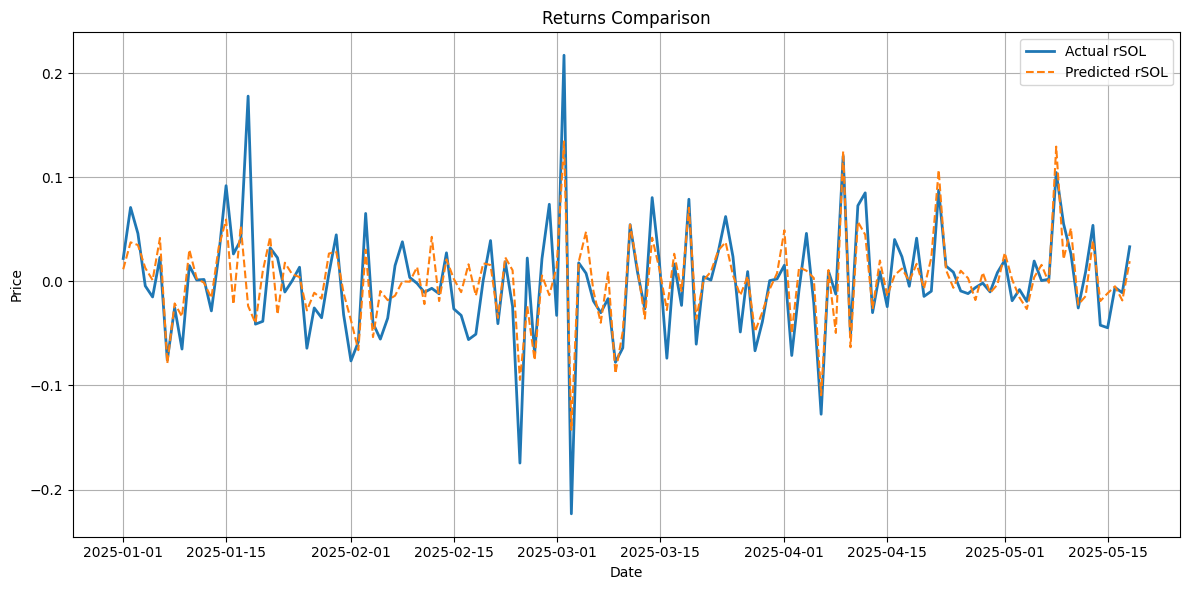

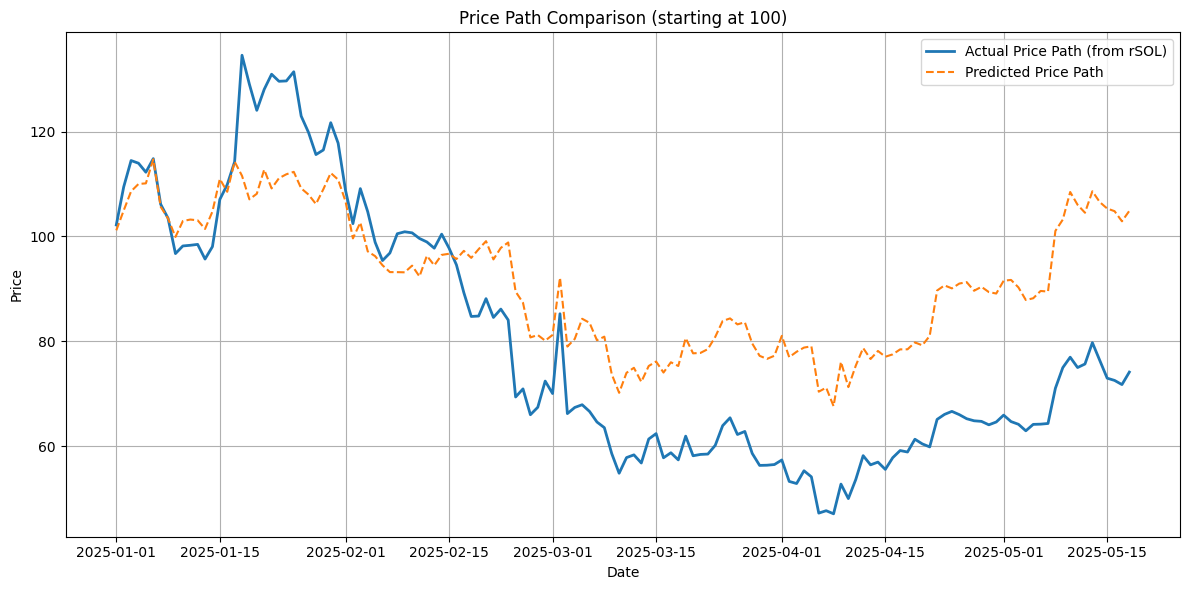

In [1193]:
####################### OLS Regression #########################################################################################################################

model_OLS = LinearRegression()

model_OLS.fit(X_shifted_train, y_shifted_train)


y_shifted_pred = model_OLS.predict(X_shifted_test)

rmse = mean_squared_error(y_shifted_test, y_shifted_pred)
r2 = r2_score(y_shifted_test, y_shifted_pred)

print("Test R²:", r2)
print("Test RMSE:", rmse)

y_shifted_test_price = 100 * (1 + y_shifted_test).cumprod()
y_shifted_pred_price = 100 * (1 + pd.Series(y_shifted_pred, index=y_shifted_test.index)).cumprod()

df_plot = pd.DataFrame({"Pred":y_shifted_pred,"Actual":y_shifted_test},index = y_shifted_test.index)

plt.figure(figsize=(12, 6))
plt.plot(df_plot.index,df_plot["Actual"], label='Actual rSOL', linewidth=2)
plt.plot(df_plot.index,df_plot["Pred"], label='Predicted rSOL', linestyle='--')
plt.title('Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_shifted_test_price, label='Actual Price Path (from rSOL)', linewidth=2)
plt.plot(y_shifted_pred_price, label='Predicted Price Path', linestyle='--')
plt.title('Price Path Comparison (starting at 100)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


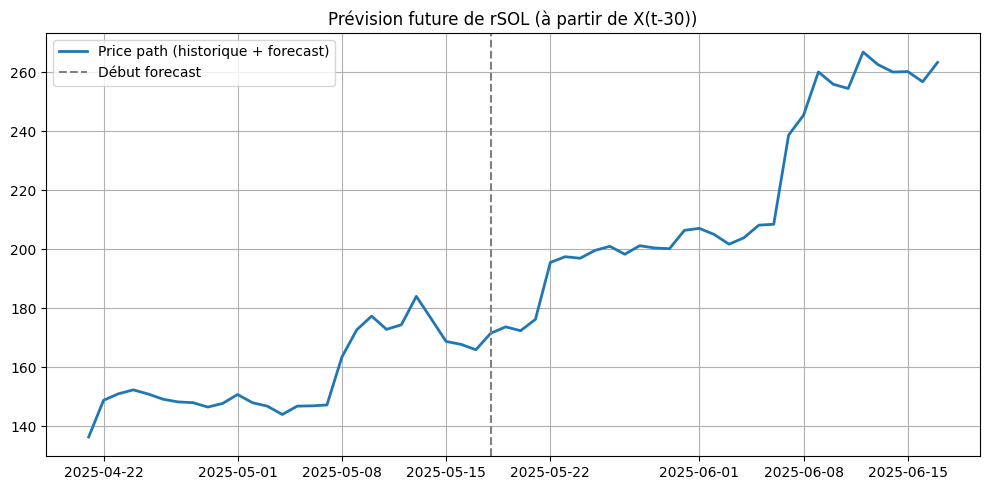

In [1194]:
####################### OLS Regression Prediction ##############################################################################################################


future_dates = pd.date_range(start=y_test.index[-1] + pd.Timedelta(days=1), periods=30)

X_future_index = pd.to_datetime(future_dates - pd.Timedelta(days=30))



X_future_index = [d for d in X_future_index if d in X_test.index]

valid_dates = [d + pd.Timedelta(days=30) for d in X_future_index]  # correspond à y(t)

# Si aucune date possible, avertir
if not X_future_index:
    print("⚠️ Tu ne peux pas prédire car tu n’as pas les variables explicatives nécessaires.")
else:
    # On récupère les X dispo
    X_future = X_test.loc[X_future_index]
    

    # Faire les prédictions avec le modèle Ridge
    y_future_pred = model_OLS.predict(X_future)

    # Mettre dans une série avec l’index correspondant
    y_future_pred = pd.Series(y_future_pred, index=valid_dates)

    # Plot vs historique

    y_combined = pd.concat([y_test[-28:], y_future_pred])
    

    price_path = 137.63 * np.exp( y_combined).cumprod()

    plt.figure(figsize=(10, 5))
    plt.plot(price_path, label="Price path (historique + forecast)", linewidth=2)
    plt.axvline(y_test.index[-1], color='gray', linestyle='--', label='Début forecast')
    plt.legend()
    plt.title("Prévision future de rSOL (à partir de X(t-30))")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


                Variable  Coefficient
2                   rBTC     0.020708
1                   rETH     0.012907
0       Commodity Factor     0.002429
3              apy block    -0.002181
4  rnetwork_active_stake    -0.000483
5                TVL_USD     0.000171
Test R²: 0.6495042754038673
Test RMSE: 0.0010065737236910413


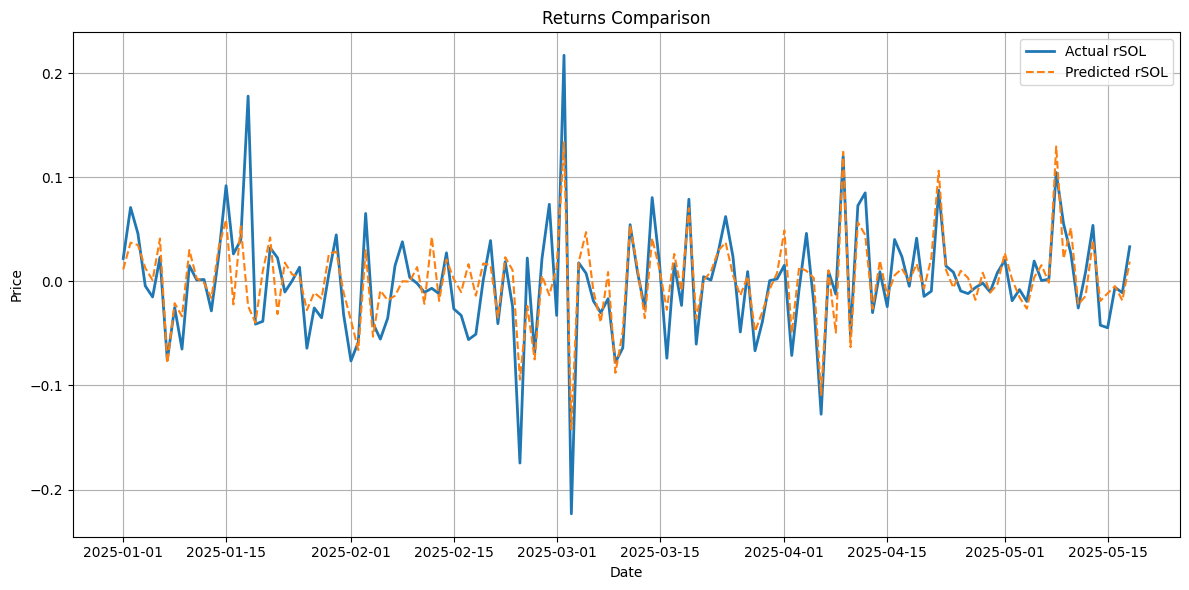

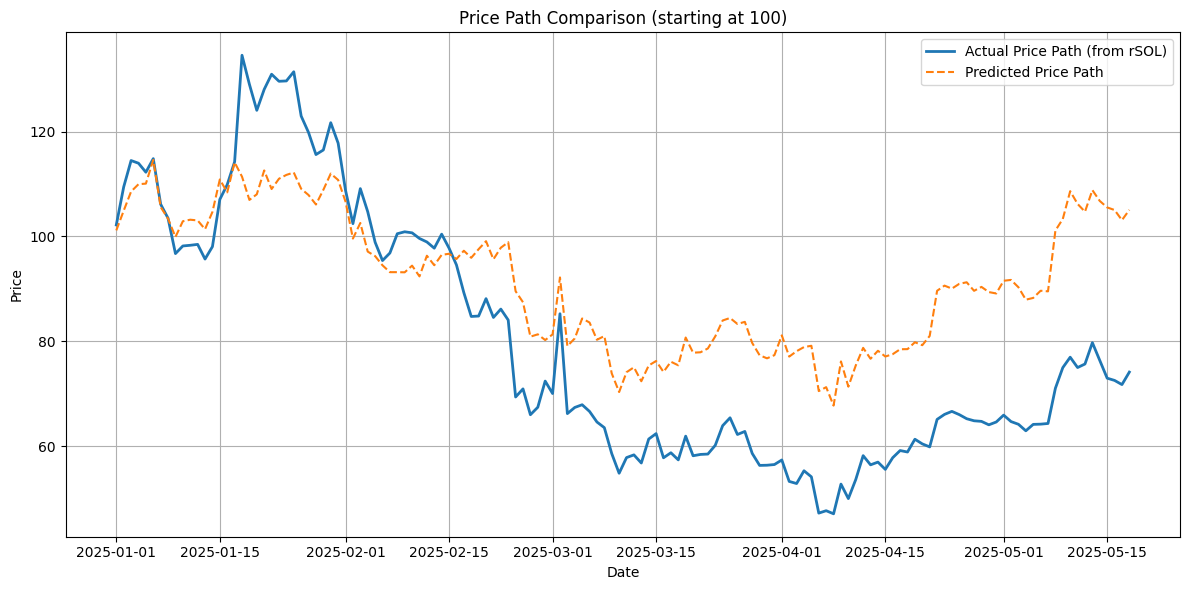

In [1195]:
####################### Rigde Regression #########################################################################################################################

model = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5)
)

ridge_result = model.fit(X_shifted_train, y_shifted_train)
feature_names = X_shifted_train.columns

# Extraire le modèle Ridge entraîné depuis le pipeline
ridge = ridge_result.named_steps['ridgecv']

# Extraire les coefficients
coefs = ridge.coef_

# Associer chaque coefficient à son nom de variable
coef_df = pd.DataFrame({
    "Variable": feature_names,
    "Coefficient": coefs
})

# Trier par importance absolue
coef_df["AbsCoeff"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("AbsCoeff", ascending=False)

print(coef_df[["Variable", "Coefficient"]])

y_shifted_pred = model.predict(X_shifted_test)

rmse = mean_squared_error(y_shifted_test, y_shifted_pred)
r2 = r2_score(y_shifted_test, y_shifted_pred)

print("Test R²:", r2)
print("Test RMSE:", rmse)

y_shifted_test_price = 100 * (1 + y_shifted_test).cumprod()
y_shifted_pred_price = 100 * (1 + pd.Series(y_shifted_pred, index=y_shifted_test.index)).cumprod()

df_plot = pd.DataFrame({"Pred":y_shifted_pred,"Actual":y_shifted_test},index = y_shifted_test.index)

plt.figure(figsize=(12, 6))
plt.plot(df_plot.index,df_plot["Actual"], label='Actual rSOL', linewidth=2)
plt.plot(df_plot.index,df_plot["Pred"], label='Predicted rSOL', linestyle='--')
plt.title('Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_shifted_test_price, label='Actual Price Path (from rSOL)', linewidth=2)
plt.plot(y_shifted_pred_price, label='Predicted Price Path', linestyle='--')
plt.title('Price Path Comparison (starting at 100)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


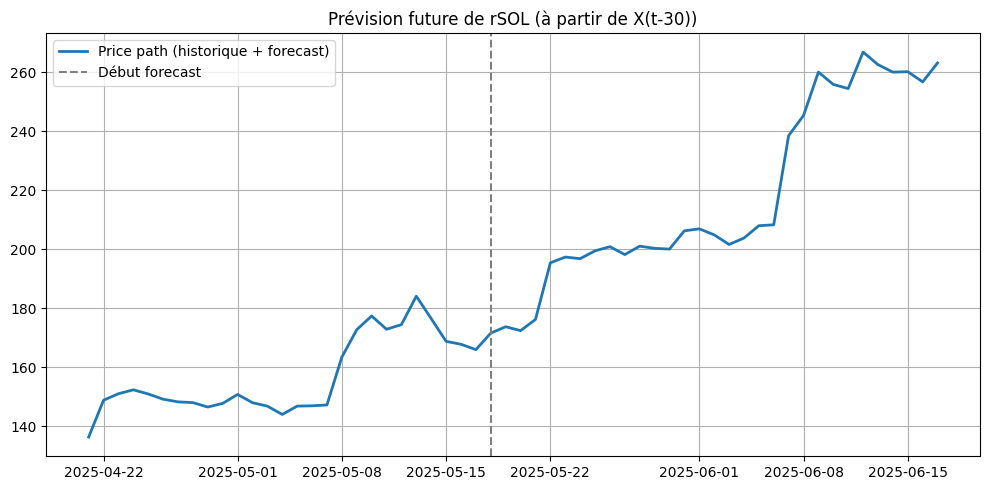

In [1196]:
####################### Rigde Regression Prediction ##############################################################################################################


future_dates = pd.date_range(start=y_test.index[-1] + pd.Timedelta(days=1), periods=30)

X_future_index = pd.to_datetime(future_dates - pd.Timedelta(days=30))



X_future_index = [d for d in X_future_index if d in X_test.index]

valid_dates = [d + pd.Timedelta(days=30) for d in X_future_index]  # correspond à y(t)

# Si aucune date possible, avertir
if not X_future_index:
    print("⚠️ Tu ne peux pas prédire car tu n’as pas les variables explicatives nécessaires.")
else:
    # On récupère les X dispo
    X_future = X_test.loc[X_future_index]
    

    # Faire les prédictions avec le modèle Ridge
    y_future_pred = model.predict(X_future)

    # Mettre dans une série avec l’index correspondant
    y_future_pred = pd.Series(y_future_pred, index=valid_dates)

    # Plot vs historique

    y_combined = pd.concat([y_test[-28:], y_future_pred])
    

    price_path = 137.63 * np.exp( y_combined).cumprod()

    plt.figure(figsize=(10, 5))
    plt.plot(price_path, label="Price path (historique + forecast)", linewidth=2)
    plt.axvline(y_test.index[-1], color='gray', linestyle='--', label='Début forecast')
    plt.legend()
    plt.title("Prévision future de rSOL (à partir de X(t-30))")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Test R²: 0.6535301316376845
Test RMSE: 0.03154381141945219


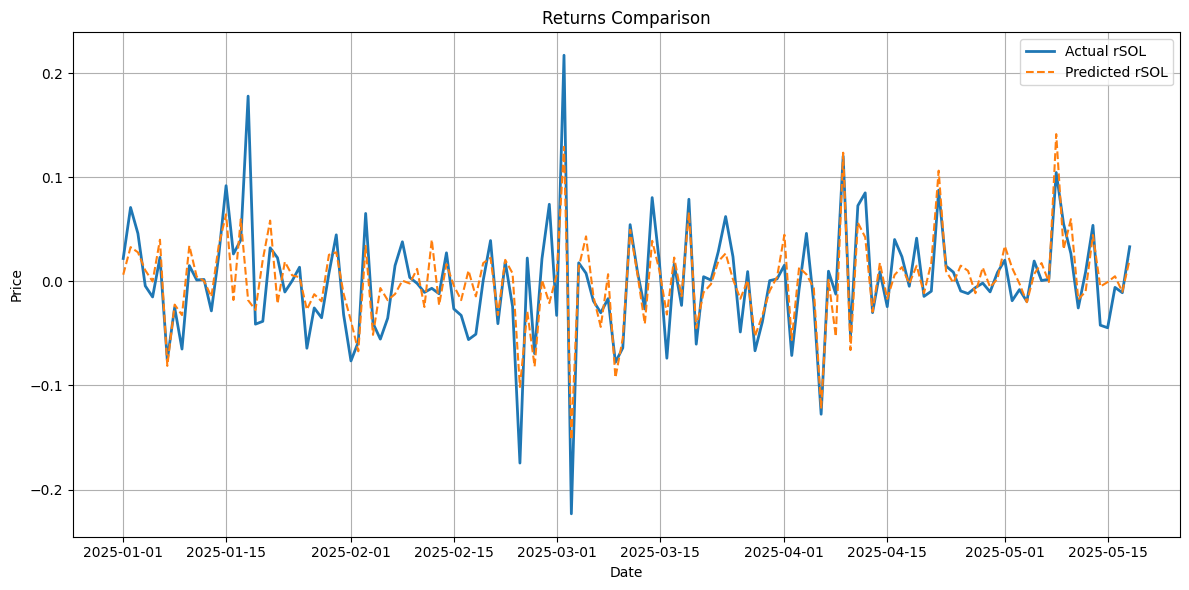

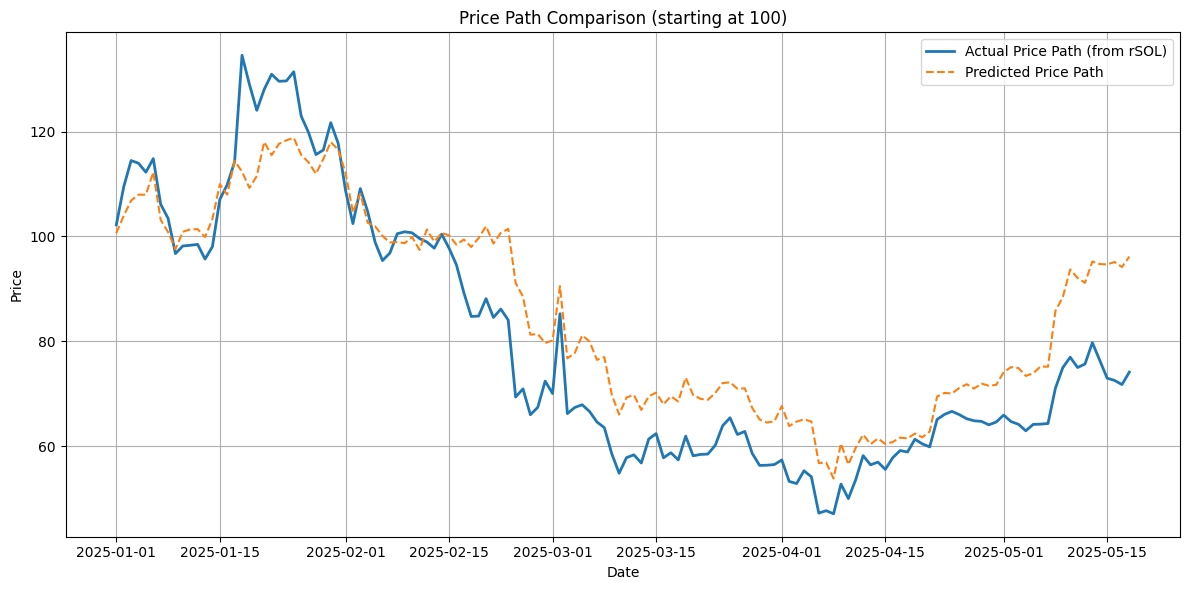

In [1197]:
####################### SARIMAX Regression NON shifted ######################################################################################################################

model_SARIMAX = sm.tsa.SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 0, 0),  
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model_SARIMAX.fit(disp=False)

# Predict on test set
y_pred = results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Evaluate
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test R²:", r2)
print("Test RMSE:", np.sqrt(rmse))

y_test_price = 100 * (1 + y_test).cumprod()
y_pred_price = 100 * (1 + pd.Series(y_pred, index=y_test.index)).cumprod()


df_plot = pd.DataFrame({"Pred":y_pred,"Actual":y_test},index = y_test.index)

plt.figure(figsize=(12, 6))
plt.plot(df_plot.index,df_plot["Actual"], label='Actual rSOL', linewidth=2)
plt.plot(df_plot.index,df_plot["Pred"], label='Predicted rSOL', linestyle='--')
plt.title('Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_price, label='Actual Price Path (from rSOL)', linewidth=2)
plt.plot(y_pred_price, label='Predicted Price Path', linestyle='--')
plt.title('Price Path Comparison (starting at 100)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


[Timestamp('2025-05-19 00:00:00'), Timestamp('2025-05-20 00:00:00'), Timestamp('2025-05-21 00:00:00'), Timestamp('2025-05-22 00:00:00'), Timestamp('2025-05-23 00:00:00'), Timestamp('2025-05-24 00:00:00'), Timestamp('2025-05-25 00:00:00'), Timestamp('2025-05-26 00:00:00'), Timestamp('2025-05-27 00:00:00'), Timestamp('2025-05-28 00:00:00'), Timestamp('2025-05-29 00:00:00'), Timestamp('2025-05-30 00:00:00'), Timestamp('2025-05-31 00:00:00'), Timestamp('2025-06-01 00:00:00'), Timestamp('2025-06-02 00:00:00'), Timestamp('2025-06-03 00:00:00'), Timestamp('2025-06-04 00:00:00'), Timestamp('2025-06-05 00:00:00'), Timestamp('2025-06-06 00:00:00'), Timestamp('2025-06-07 00:00:00'), Timestamp('2025-06-08 00:00:00'), Timestamp('2025-06-09 00:00:00'), Timestamp('2025-06-10 00:00:00'), Timestamp('2025-06-11 00:00:00'), Timestamp('2025-06-12 00:00:00'), Timestamp('2025-06-13 00:00:00'), Timestamp('2025-06-14 00:00:00'), Timestamp('2025-06-15 00:00:00'), Timestamp('2025-06-16 00:00:00'), Timestamp('20

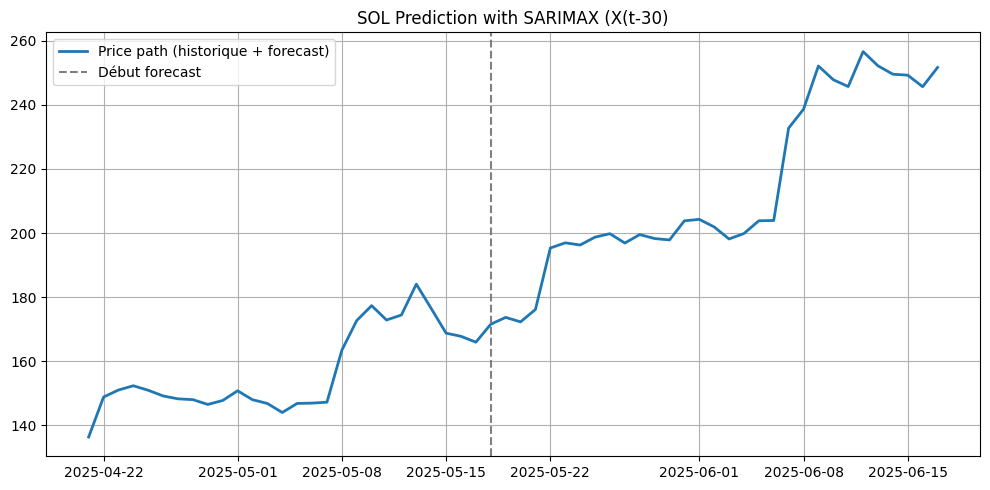

# 5. Prédictions avec intervalle de confiance
2025-05-19   -0.049117
2025-05-20   -0.069707
2025-05-21   -0.039301
2025-05-22    0.041826
2025-05-23   -0.053332
2025-05-24   -0.065006
2025-05-25   -0.049126
2025-05-26   -0.056147
2025-05-27   -0.076290
2025-05-28   -0.048239
2025-05-29   -0.067732
2025-05-30   -0.063814
2025-05-31   -0.031863
2025-06-01   -0.059231
2025-06-02   -0.073260
2025-06-03   -0.080358
2025-06-04   -0.052965
2025-06-05   -0.041874
2025-06-06   -0.061113
2025-06-07    0.070715
2025-06-08   -0.036589
2025-06-09   -0.006488
2025-06-10   -0.078738
2025-06-11   -0.070198
2025-06-12   -0.018105
2025-06-13   -0.079007
2025-06-14   -0.071991
2025-06-15   -0.062777
2025-06-16   -0.076095
2025-06-17   -0.037440
Name: lower rSOL, dtype: float64


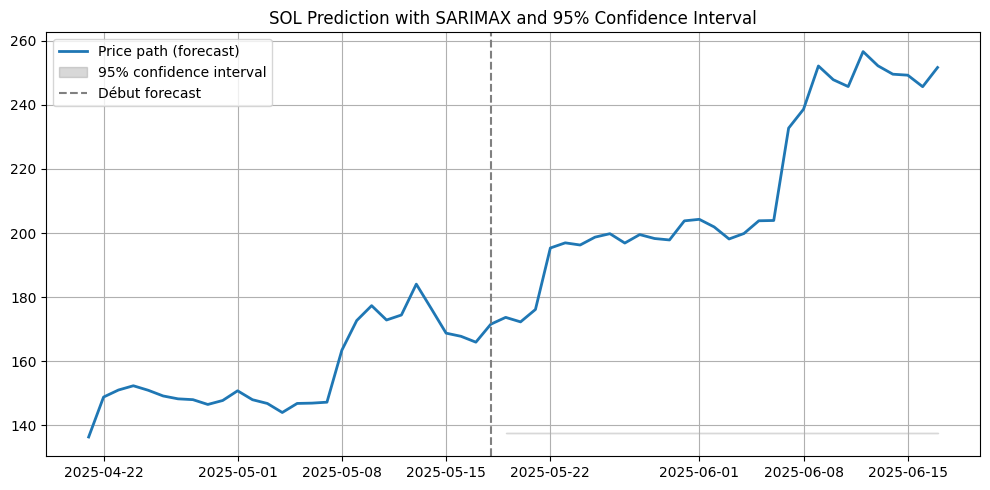

In [1198]:
####################### SARIMAX Regression Prediction ##############################################################################################################

model_SARIMAX = sm.tsa.SARIMAX(
    y_shifted,
    exog=X_shifted,
    order=(1, 0, 0),  
    enforce_stationarity=False,
    enforce_invertibility=False
)
results2 = model_SARIMAX.fit(disp=False)



# 1. Générer les dates futures à prédire (ex: 30 jours)
future_dates = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=30)

# 2. Créer les index des X nécessaires : X(t-30) pour prédire y(t)
X_future_index = (future_dates - pd.Timedelta(days=30)).normalize()
X_shifted.index = pd.to_datetime(X_shifted.index).normalize()

# 3. Ne garder que les dates disponibles dans X_test
X_future_index = [d for d in X_future_index if d in X_shifted.index]

valid_dates = [d + pd.Timedelta(days=30) for d in X_future_index]
print(valid_dates)

# 4. Vérification
if not X_future_index:
    print("⚠️ Tu ne peux pas prédire car tu n’as pas les variables explicatives nécessaires.")
else:
    X_future = X.loc[X_future_index]

    # 5. Prédictions avec le modèle SARIMAX
    start_idx = len(y_shifted)

    end_idx = start_idx + len(X_future) - 1

    y_future_pred = results2.predict(
        start=start_idx,
        end=end_idx,
        exog=X_future
    )

    y_future_pred = pd.Series(y_future_pred, index=valid_dates)


    # 6. Visualisation du price path
    y_combined = pd.concat([y_test[-28:], y_future_pred])
    price_path = 137.63 * np.exp(y_combined).cumprod()  # ou np.exp() si returns sont log

    plt.figure(figsize=(10, 5))
    plt.plot(price_path, label="Price path (historique + forecast)", linewidth=2)
    plt.axvline(y_test.index[-1], color='gray', linestyle='--', label='Début forecast')
    plt.legend()
    plt.title("SOL Prediction with SARIMAX (X(t-30)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("# 5. Prédictions avec intervalle de confiance")
    pred = results2.get_prediction(start=start_idx, end=end_idx, exog=X_future)
    pred_mean = pd.Series(pred.predicted_mean, index=valid_dates)
    conf_int = pred.conf_int(alpha=0.05)
    lower = pd.Series(conf_int.iloc[:, 0], index=valid_dates)
    upper = pd.Series(conf_int.iloc[:, 1], index=valid_dates)
    print(lower)

    # 6. Visualisation du price path avec IC
    y_combined = pd.concat([y_test[-28:], pred_mean])
    price_path = 137.63 * np.exp(y_combined).cumprod()

    lower_path = 137.63 * np.exp(pd.concat([y_test[-28:], lower]).cumprod())
    upper_path = 137.63 * np.exp(pd.concat([y_test[-28:], upper]).cumprod())

    plt.figure(figsize=(10, 5))
    plt.plot(price_path, label="Price path (forecast)", linewidth=2)
    plt.fill_between(pred_mean.index, lower_path[-len(pred_mean):], upper_path[-len(pred_mean):],
                    color='gray', alpha=0.3, label='95% confidence interval')
    plt.axvline(y_test.index[-1], color='gray', linestyle='--', label='Début forecast')
    plt.legend()
    plt.title("SOL Prediction with SARIMAX and 95% Confidence Interval")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




Test R²: 0.6489571554348826
Test RMSE: 0.03175129877968228


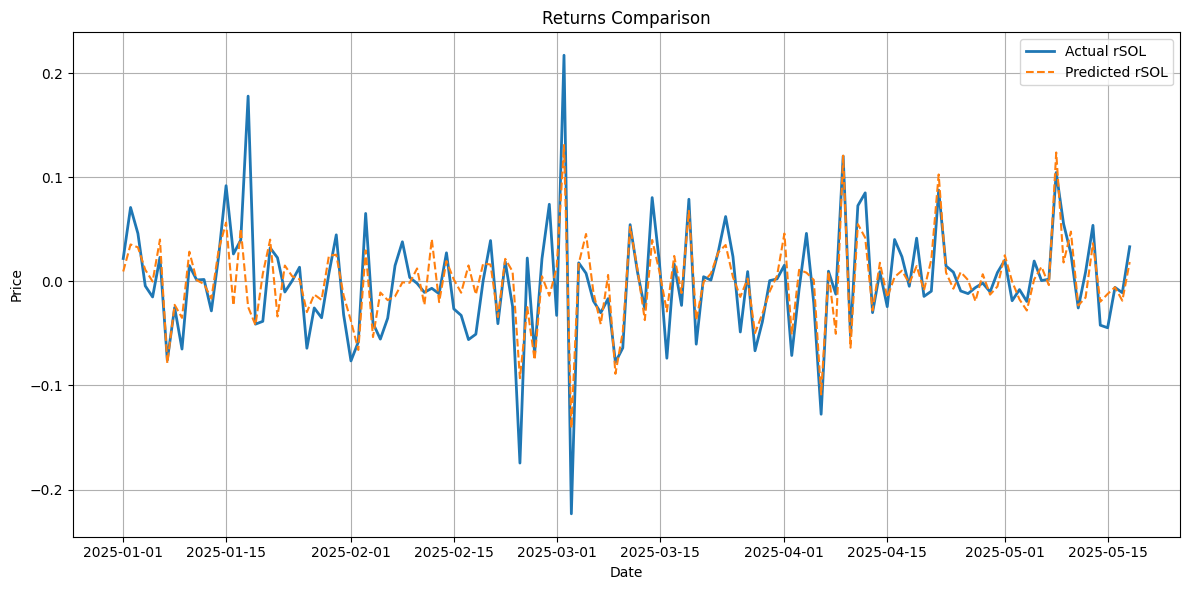

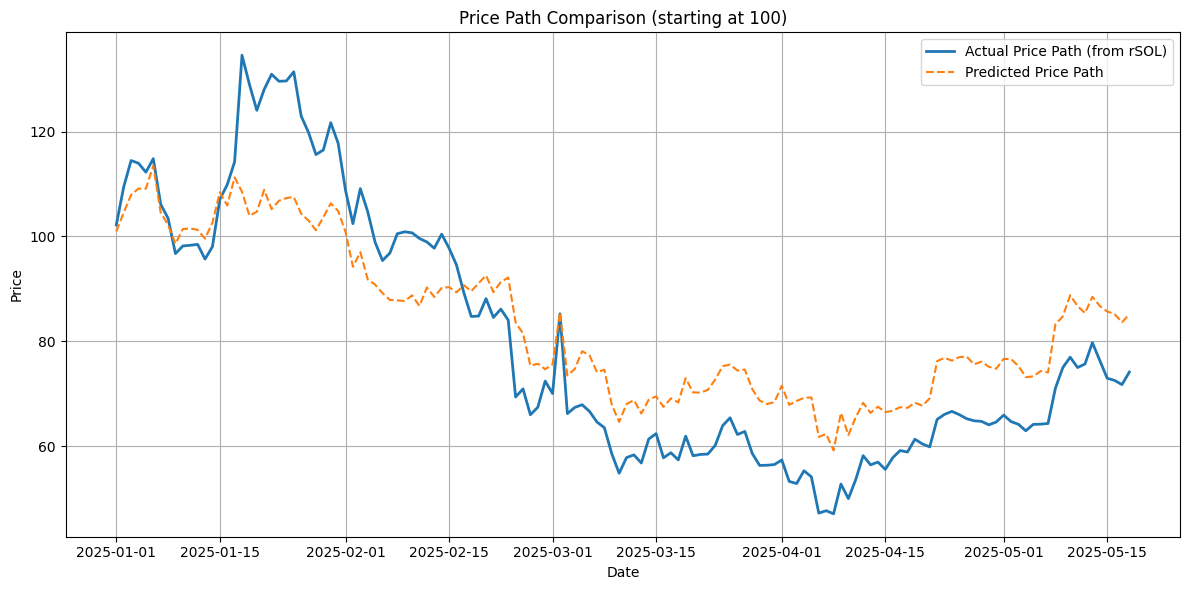

In [1199]:
####################### SARIMAX Regression ######################################################################################################################


model_SARIMAX = sm.tsa.SARIMAX(
    y_shifted_train,
    exog=X_shifted_train,
    order=(1, 0, 0),  
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model_SARIMAX.fit(disp=False)

# Predict on test set
y_shifted_pred = results.predict(start=len(y_shifted_train), end=len(y_shifted_train) + len(y_shifted_test) - 1, exog=X_shifted_test)

# Evaluate
rmse = mean_squared_error(y_shifted_test, y_shifted_pred)
r2 = r2_score(y_shifted_test, y_shifted_pred)

print("Test R²:", r2)
print("Test RMSE:", np.sqrt(rmse))

y_test_price = 100 * (1 + y_shifted_test).cumprod()
y_pred_price = 100 * (1 + pd.Series(y_shifted_pred, index=y_shifted_test.index)).cumprod()


df_plot = pd.DataFrame({"Pred":y_shifted_pred,"Actual":y_shifted_test},index = y_shifted_test.index)

plt.figure(figsize=(12, 6))
plt.plot(df_plot.index,df_plot["Actual"], label='Actual rSOL', linewidth=2)
plt.plot(df_plot.index,df_plot["Pred"], label='Predicted rSOL', linestyle='--')
plt.title('Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_price, label='Actual Price Path (from rSOL)', linewidth=2)
plt.plot(y_pred_price, label='Predicted Price Path', linestyle='--')
plt.title('Price Path Comparison (starting at 100)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



1. Test de normalité des résidus :
Jarque-Bera: p-value = 0.0000, Skew = 1.42, Kurtosis = 9.81
❌ Résidus non normalement distribués (Jarque-Bera)
Shapiro-Wilk: p-value = 0.0000
❌ Résidus non normalement distribués (Shapiro-Wilk)


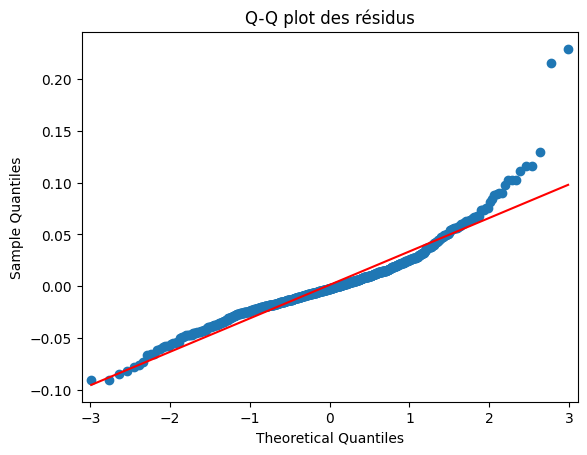


2. Test de Breusch-Pagan (hétéroscédasticité) :
Lagrange multiplier statistic: 11.3565
p-value: 0.0780
f-value: 1.9044
f p-value: 0.0777
✅ Homoscédasticité (variance constante des erreurs)


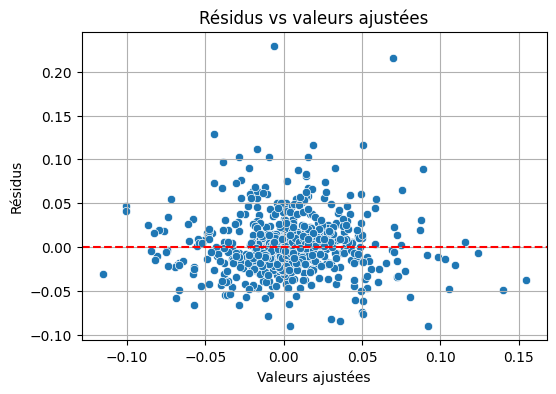


3. Test de Durbin-Watson (autocorrélation) :
Durbin-Watson: 1.9338
✅ Pas d'autocorrélation suspecte des résidus

4. Test de spécification du modèle (Ramsey RESET) :
RESET (Ramsey): p-value = 0.0257
❌ Le modèle est probablement mal spécifié (variable manquante ou non-linéarité)


In [1200]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import reset_ramsey
from scipy.stats import shapiro

# Résidus et valeurs ajustées
residuals = results.resid
fitted = results.fittedvalues

# --- 1. Normalité des résidus ---
print("\n1. Test de normalité des résidus :")

# Jarque-Bera
jb_stat, jb_pvalue, skew, kurt = sms.jarque_bera(residuals)
print(f"Jarque-Bera: p-value = {jb_pvalue:.4f}, Skew = {skew:.2f}, Kurtosis = {kurt:.2f}")
if jb_pvalue < 0.05:
    print("❌ Résidus non normalement distribués (Jarque-Bera)")
else:
    print("✅ Résidus normalement distribués (Jarque-Bera)")

# Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Shapiro-Wilk: p-value = {shapiro_p:.4f}")
if shapiro_p < 0.05:
    print("❌ Résidus non normalement distribués (Shapiro-Wilk)")
else:
    print("✅ Résidus normalement distribués (Shapiro-Wilk)")

# QQ plot
sm.qqplot(residuals, line='s')
plt.title("Q-Q plot des résidus")
plt.show()

# --- 2. Hétéroscédasticité (Breusch-Pagan) ---
print("\n2. Test de Breusch-Pagan (hétéroscédasticité) :")

# Ajouter la constante à X
X_test_bp = sm.add_constant(X_shifted_train)

bp_test = sms.het_breuschpagan(residuals, X_test_bp)
bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for name, value in zip(bp_labels, bp_test):
    print(f"{name}: {value:.4f}")
if bp_test[1] < 0.05:
    print("❌ Hétéroscédasticité détectée (variance non constante)")
else:
    print("✅ Homoscédasticité (variance constante des erreurs)")

# Résidus vs fitted
plt.figure(figsize=(6,4))
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus vs valeurs ajustées")
plt.xlabel("Valeurs ajustées")
plt.ylabel("Résidus")
plt.grid(True)
plt.show()

# --- 3. Autocorrélation des erreurs (Durbin-Watson) ---
print("\n3. Test de Durbin-Watson (autocorrélation) :")
dw = sm.stats.stattools.durbin_watson(residuals)
print(f"Durbin-Watson: {dw:.4f}")
if dw < 1.5 or dw > 2.5:
    print("❌ Autocorrélation probable des résidus")
else:
    print("✅ Pas d'autocorrélation suspecte des résidus")

# --- 4. Spécification du modèle (RESET) ---
print("\n4. Test de spécification du modèle (Ramsey RESET) :")
reset = reset_ramsey(results, degree=3)
print(f"RESET (Ramsey): p-value = {reset.pvalue:.4f}")
if reset.pvalue < 0.05:
    print("❌ Le modèle est probablement mal spécifié (variable manquante ou non-linéarité)")
else:
    print("✅ Pas de problème détecté dans la spécification du modèle")

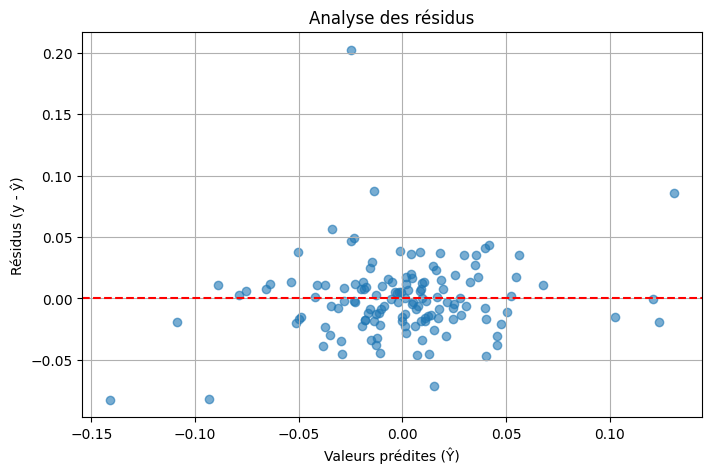

In [1201]:

residuals = y_shifted_test- y_shifted_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_shifted_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')

plt.xlabel("Valeurs prédites (Ŷ)")
plt.ylabel("Résidus (y - ŷ)")
plt.title("Analyse des résidus")
plt.grid(True)
plt.show()

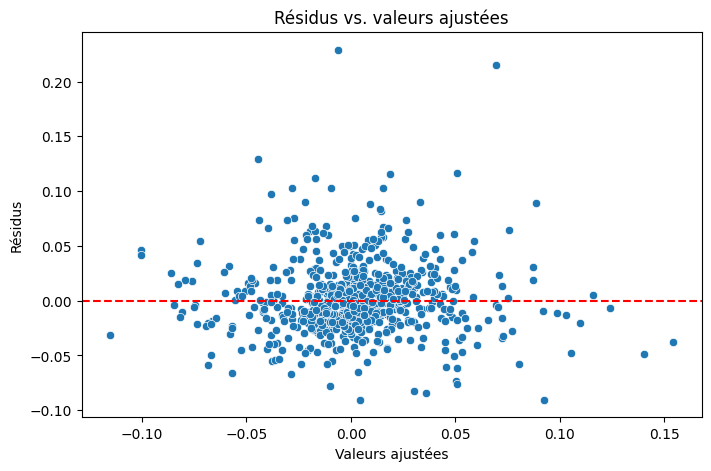

In [1202]:

import matplotlib.pyplot as plt
import seaborn as sns

fitted_vals = results.fittedvalues
residuals = results.resid

plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valeurs ajustées')
plt.ylabel('Résidus')
plt.title('Résidus vs. valeurs ajustées')
plt.show()



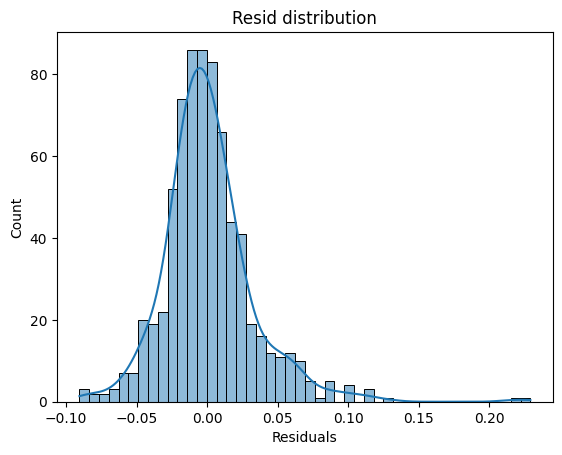

In [1203]:
sns.histplot(residuals, kde=True)
plt.title('Resid distribution')
plt.xlabel('Residuals')
plt.show()



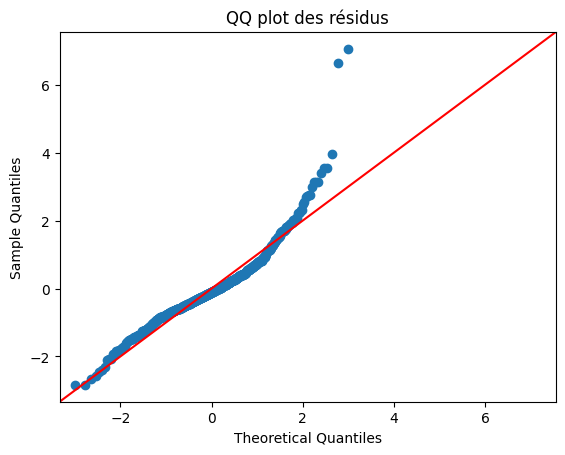

In [1204]:
import statsmodels.api as sm

sm.qqplot(residuals, line='45', fit=True)
plt.title('QQ plot des résidus')
plt.show()


Commodity Factor         0.001981
rETH                     0.411928
rBTC                     0.843996
apy block               -0.001453
rnetwork_active_stake   -0.006453
TVL_USD                  0.000394
ar.L1                    0.053575
sigma2                   0.000981
dtype: float64


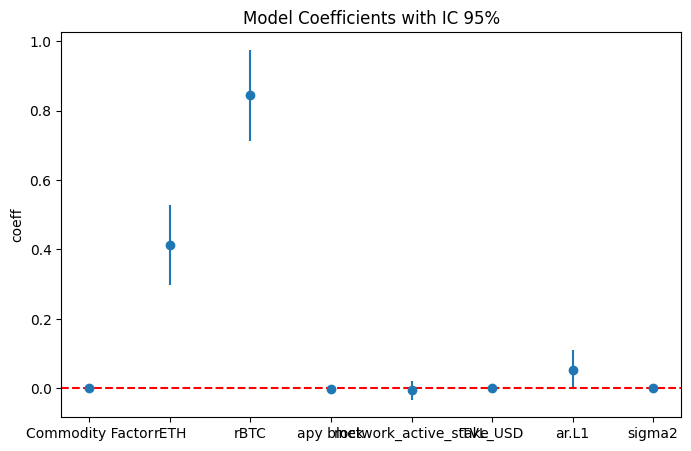

In [1205]:

params = results.params
conf = results.conf_int()
errors = results.bse

print(params)
plt.figure(figsize=(8, 5))
plt.errorbar(params.index, params.values, 
             yerr=1.96 * errors, fmt='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Model Coefficients with IC 95%")
plt.ylabel("coeff")
plt.show()

In [1206]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                variable       VIF
0       Commodity Factor  1.057511
1                   rETH  2.834133
2                   rBTC  2.832284
3              apy block  1.111913
4  rnetwork_active_stake  1.005761
5                TVL_USD  1.162645


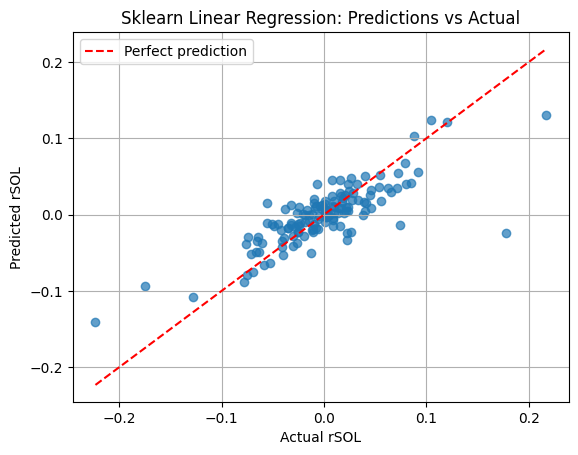

DatetimeIndex(['2025-01-01', '2025-01-02', '2025-01-03', '2025-01-04',
               '2025-01-05', '2025-01-06', '2025-01-07', '2025-01-08',
               '2025-01-09', '2025-01-10',
               ...
               '2025-05-09', '2025-05-10', '2025-05-11', '2025-05-12',
               '2025-05-13', '2025-05-14', '2025-05-15', '2025-05-16',
               '2025-05-17', '2025-05-18'],
              dtype='datetime64[ns]', length=138, freq='D')


In [1207]:
import matplotlib.pyplot as plt

plt.scatter(y_shifted_test, y_shifted_pred, alpha=0.7)
plt.plot([y_shifted_test.min(), y_shifted_test.max()], [y_shifted_test.min(), y_shifted_test.max()], 'r--', label='Perfect prediction')
plt.xlabel("Actual rSOL")
plt.ylabel("Predicted rSOL")
plt.title("Sklearn Linear Regression: Predictions vs Actual")
plt.legend()
plt.grid(True)
plt.show()

print(y_test.index)

In [1208]:
from statsmodels.stats.outliers_influence import reset_ramsey
reset_ramsey(results,degree=4)



<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=2.469175000265388, p=0.06087812232633619, df_denom=709, df_num=3>

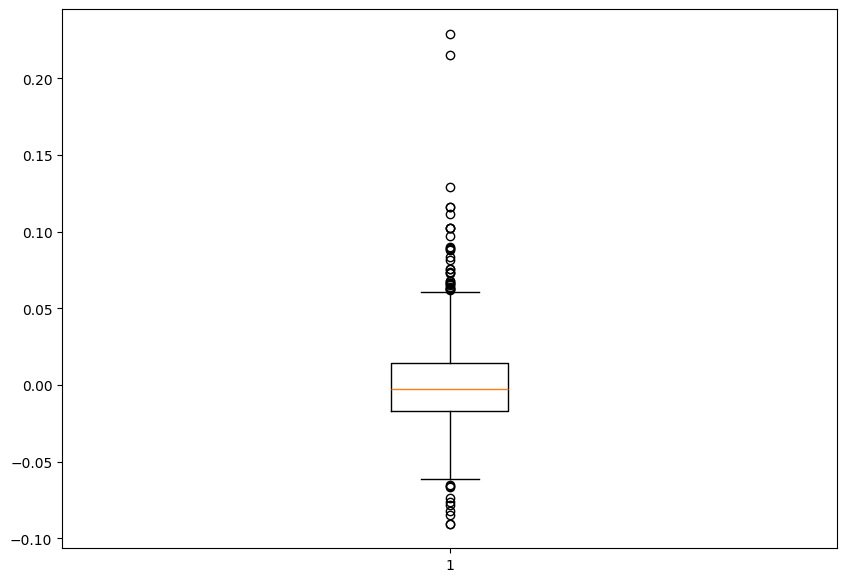

In [1209]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(results.resid)
plt.show()

In [1210]:
# Detecting the smallest values date
residuals.nsmallest(5)
# Detecting the largest values date
residuals.nlargest(5)



2023-11-10    0.229077
2023-01-14    0.215295
2023-11-14    0.129423
2023-07-13    0.116268
2023-12-21    0.115904
dtype: float64

In [1211]:
residuals = results.resid

jb, chi, sk, ku = sms.jarque_bera(residuals)
print('Jarque-Bera statistics=%.3f, Chi^2 two-tail p-val=%.3f, Skew =%.3f, Kurtosis=%.3f' % (jb, chi, sk, ku))

# Shapiro-Wilk Test
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print('Shapiro statistics=%.3f, p=%.3f' % (stat, p))



Jarque-Bera statistics=1627.068, Chi^2 two-tail p-val=0.000, Skew =1.416, Kurtosis=9.809
Shapiro statistics=0.916, p=0.000


Test R²: 0.573495328450994
Test RMSE: 0.03499800818405564


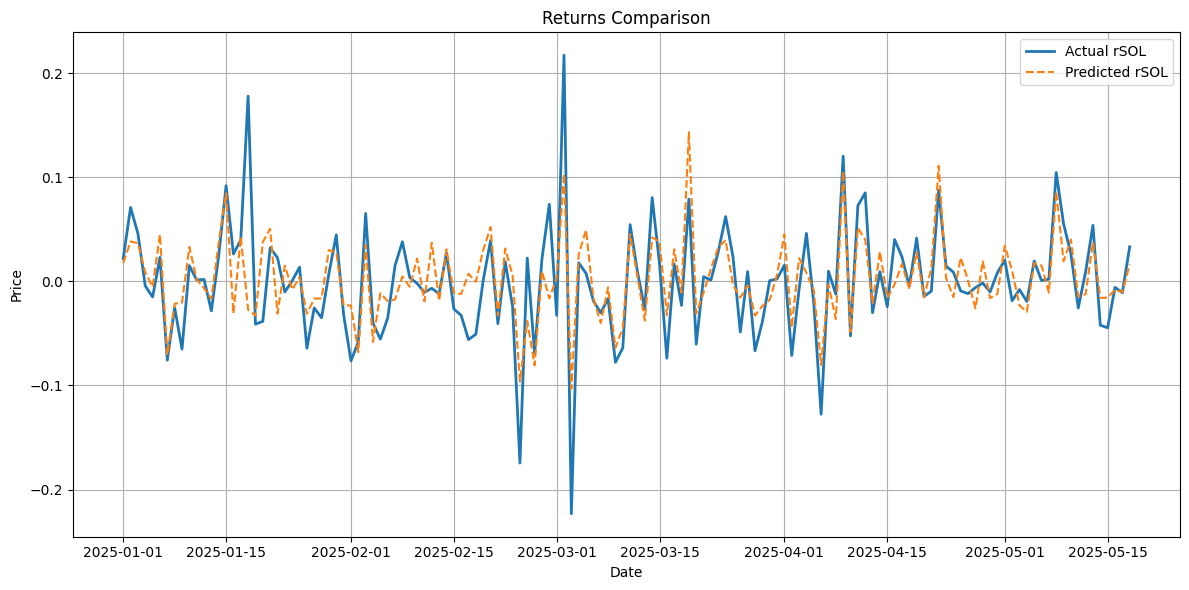

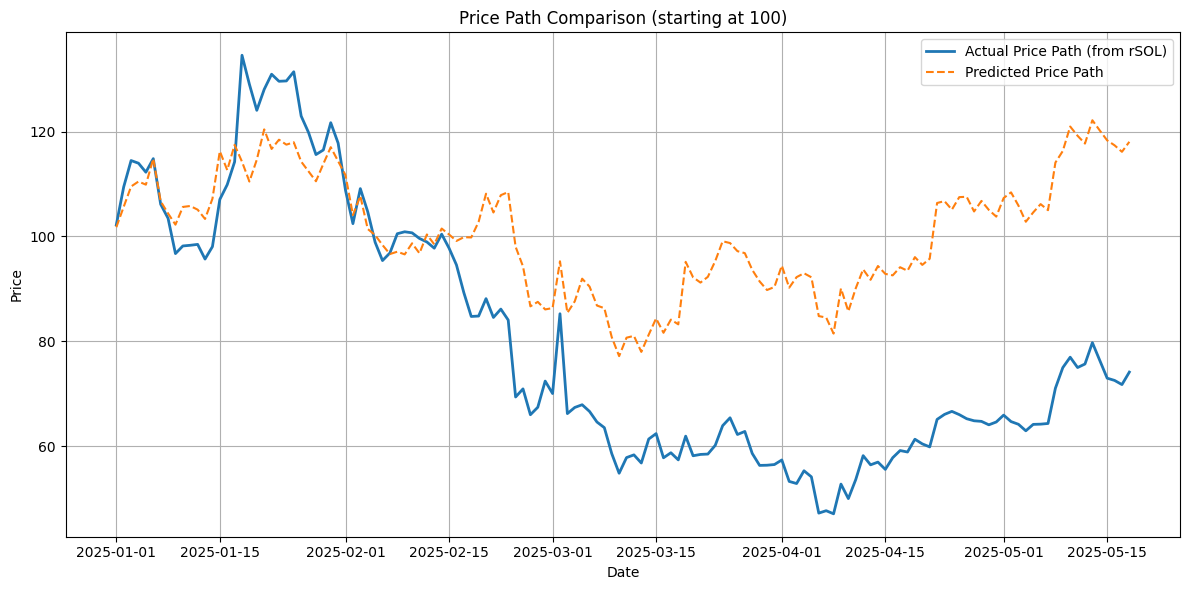

In [1212]:

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=1000, max_depth=6, random_state=42)
results = model.fit(X_shifted_train, y_shifted_train)
y_shifted_pred = model.predict(X_shifted_test)

rmse = mean_squared_error(y_shifted_test, y_shifted_pred)
r2 = r2_score(y_shifted_test, y_shifted_pred)

print("Test R²:", r2)
print("Test RMSE:", np.sqrt(rmse))

y_test_price = 100 * (1 + y_shifted_test).cumprod()
y_pred_price = 100 * (1 + pd.Series(y_shifted_pred, index=y_shifted_test.index)).cumprod()


df_plot = pd.DataFrame({"Pred":y_shifted_pred,"Actual":y_shifted_test},index = y_shifted_test.index)

plt.figure(figsize=(12, 6))
plt.plot(df_plot.index,df_plot["Actual"], label='Actual rSOL', linewidth=2)
plt.plot(df_plot.index,df_plot["Pred"], label='Predicted rSOL', linestyle='--')
plt.title('Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_price, label='Actual Price Path (from rSOL)', linewidth=2)
plt.plot(y_pred_price, label='Predicted Price Path', linestyle='--')
plt.title('Price Path Comparison (starting at 100)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [1213]:
from arch import arch_model
import pandas as pd

# Préparation des exogènes : il faut les aligner avec y
# (évite les NaN, assure l'index identique)
y = y_shifted_train
X = X_shifted_train.loc[y.index]

# Fit un modèle AR(1) + GARCH(1,1) avec X comme variables exogènes
model_garch = arch_model(
    y, 
    vol='Garch', 
    p=1, q=1,
    mean='ARX', 
    lags=1,
    x=X,
    rescale=False  # important si tu as des retours faibles (ex: crypto)
)

results_garch = model_garch.fit(disp='off')
print(results_garch.summary())

forecast = results_garch.forecast(horizon=10, start=None, method='simulation')

# Moyenne prévue
mean_forecast = forecast.mean.iloc[-1]

# Volatilité prévue (écart-type)
vol_forecast = forecast.variance.iloc[-1] ** 0.5

print("Forecasted mean returns:")
print(mean_forecast)

print("Forecasted volatility (std):")
print(vol_forecast)

                          AR-X - GARCH Model Results                          
Dep. Variable:                   rSOL   R-squared:                       0.501
Mean Model:                      AR-X   Adj. R-squared:                  0.496
Vol Model:                      GARCH   Log-Likelihood:                1496.43
Distribution:                  Normal   AIC:                          -2970.86
Method:            Maximum Likelihood   BIC:                          -2920.54
                                        No. Observations:                  717
Date:                Thu, May 22 2025   Df Residuals:                      709
Time:                        12:30:15   Df Model:                            8
                                        Mean Model                                       
                             coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------------------
Const              

TypeError: x is None but the model contains exogenous variables. You must provide expected values to use for the exogenous variables to construct forecasts.